# Local Feature Detection and Matching

This notebook demonstrates SIFT keypoints, Harris corners, and feature matching filtered with RANSAC on simple synthetic images.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6)


## Create synthetic image pair
We generate a base image with simple geometric shapes and a second image by rotating and translating the original. This makes it easy to visualize feature detection and matching.

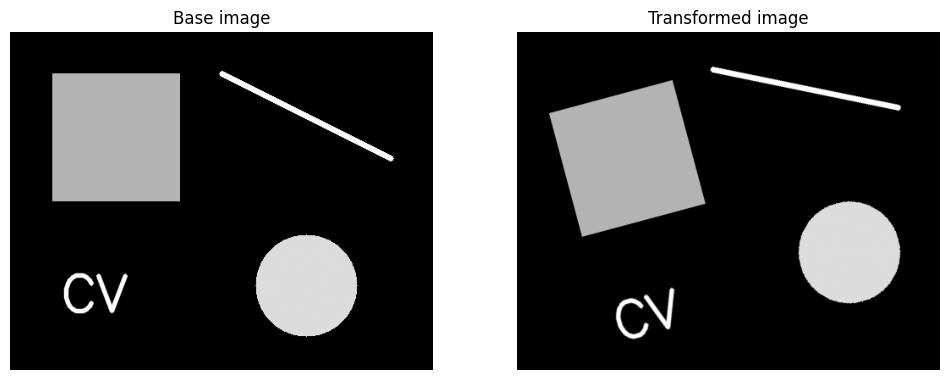

In [3]:
# Create a synthetic grayscale image
base = np.zeros((400, 500), dtype=np.uint8)
cv2.rectangle(base, (50, 50), (200, 200), 180, -1)
cv2.circle(base, (350, 300), 60, 220, -1)
cv2.line(base, (250, 50), (450, 150), 255, 5)
cv2.putText(base, 'CV', (60, 330), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3, cv2.LINE_AA)

# Apply an affine transform to create a second view
angle = 15
scale = 1.0
M = cv2.getRotationMatrix2D((base.shape[1]//2, base.shape[0]//2), angle, scale)
M[:, 2] += np.array([20, -10])  # small translation
transformed = cv2.warpAffine(base, M, (base.shape[1], base.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(base, cmap='gray')
axes[0].set_title('Base image')
axes[0].axis('off')
axes[1].imshow(transformed, cmap='gray')
axes[1].set_title('Transformed image')
axes[1].axis('off')
plt.show()


## SIFT keypoints
Detect SIFT keypoints and visualize their distribution on both images.

Base keypoints: 37
Transformed keypoints: 63


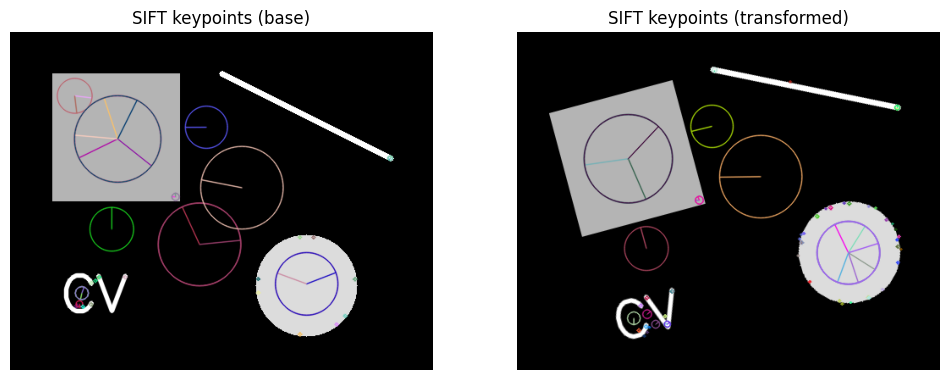

In [4]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(base, None)
kp2, des2 = sift.detectAndCompute(transformed, None)

print(f'Base keypoints: {len(kp1)}')
print(f'Transformed keypoints: {len(kp2)}')

vis1 = cv2.drawKeypoints(base, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis2 = cv2.drawKeypoints(transformed, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(vis1, cmap='gray')
axes[0].set_title('SIFT keypoints (base)')
axes[0].axis('off')
axes[1].imshow(vis2, cmap='gray')
axes[1].set_title('SIFT keypoints (transformed)')
axes[1].axis('off')
plt.show()


## Harris corners
Compute a Harris corner map and overlay the strongest responses on each image.

Harris corners (base): 1029
Harris corners (transformed): 588


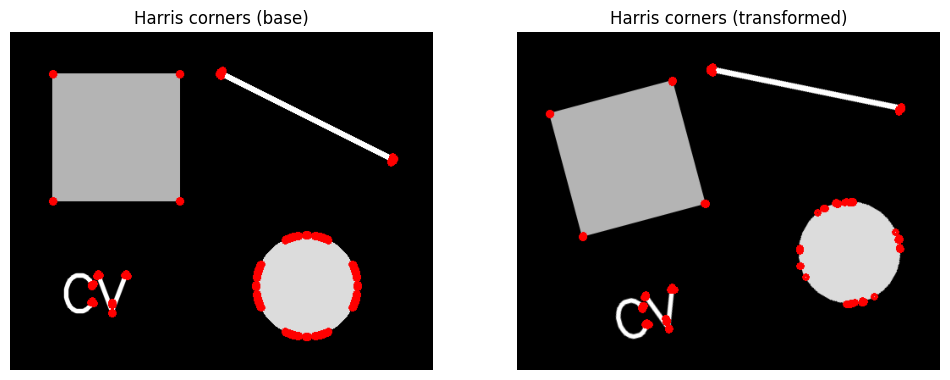

In [5]:
def harris_corners(gray, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    gray_f = np.float32(gray)
    dst = cv2.cornerHarris(gray_f, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    threshold = threshold_ratio * dst.max()
    corners = np.argwhere(dst > threshold)
    return corners

corners1 = harris_corners(base)
corners2 = harris_corners(transformed)

color1 = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
color2 = cv2.cvtColor(transformed, cv2.COLOR_GRAY2BGR)
for y, x in corners1:
    cv2.circle(color1, (x, y), 3, (0, 0, 255), 1)
for y, x in corners2:
    cv2.circle(color2, (x, y), 3, (0, 0, 255), 1)

print(f'Harris corners (base): {len(corners1)}')
print(f'Harris corners (transformed): {len(corners2)}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(color1[..., ::-1])
axes[0].set_title('Harris corners (base)')
axes[0].axis('off')
axes[1].imshow(color2[..., ::-1])
axes[1].set_title('Harris corners (transformed)')
axes[1].axis('off')
plt.show()


## Feature matching with RANSAC
Match SIFT descriptors using a ratio test, then estimate a homography with RANSAC to discard outliers.

Good matches after ratio test: 18
Homography: [[ 9.55780794e-01  2.59664078e-01 -2.27330062e+01]
 [-2.58528027e-01  9.69545992e-01  6.05933944e+01]
 [-2.13288602e-05  7.63392474e-06  1.00000000e+00]]
Inlier matches after RANSAC: 13


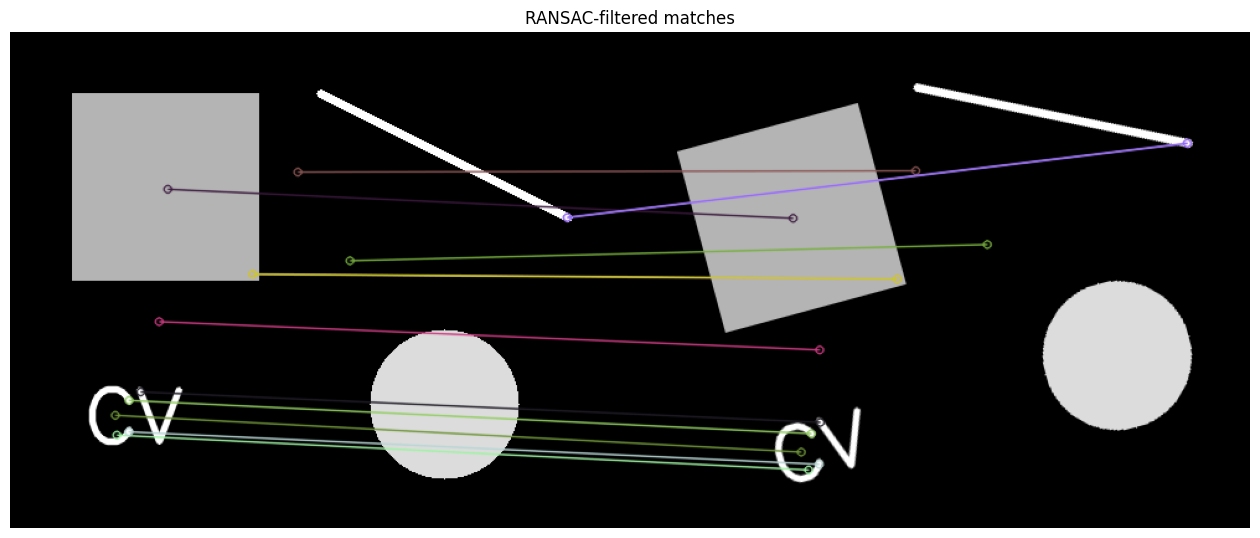

In [7]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Lowe's ratio test
ratio = 0.75
good = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

print(f'Good matches after ratio test: {len(good)}')

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
print('Homography:', H)

mask = mask.ravel().tolist() if mask is not None else []
inlier_matches = [g for g, keep in zip(good, mask) if keep]
print(f'Inlier matches after RANSAC: {len(inlier_matches)}')

match_vis = cv2.drawMatches(base, kp1, transformed, kp2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 8))
plt.imshow(match_vis)
plt.title('RANSAC-filtered matches')
plt.axis('off')
plt.show()
